In [1]:
%matplotlib inline


# Constant Properties

This example shows step by step how to set up and run a model of a cooling
planetesimal without using a parameters file. This example uses constant
material properties in the mantle and reproduces the results of
[Murphy Quinlan et al. (2021)](https://doi.org/10.1029/2020JE006726).


First we import the required `pytesimal` modules. To allow this
example to run without the package installed, we import these
modules from the `context.py` script, which adds the package
directory to the python path. This isn't required once the
package is installed; instead modules can be loaded with
`import pytesimal.numerical_methods` etc.

As we're setting this up step-by-step instead of using the
`pytesimal.quick_workflow` module, we need to import a
selection of modules:



In [2]:
# Roundabout import without package installed
from context import setup_functions
from context import load_plot_save
from context import numerical_methods
from context import analysis
from context import core_function
from context import mantle_properties

Instead of creating and loading a parameter file, we're going to
define variables here. The values match those of the constant
thermal properties case in Murphy Quinlan et al. (2021):



In [3]:
mantle_diffusivity = 5e-7
mantle_conductivity_value = 3.0
mantle_density_value = 3000.0

# this value isn't explicitly listed in Bryson et al., or references
# because the model uses diffusivity (quoted above)
mantle_heatcap_value = mantle_conductivity_value/(mantle_density_value * mantle_diffusivity)

timestep = 2E11  # s

# Bryson et al., 2015 add megaregolith to the total planetary radius
r_planet = 200_000.0 # + 8_000.0 # m

reg_m = 8_000.0 # megaregolith thickness in m
reg_fraction = reg_m/r_planet  # fraction of r_planet

# We don't want to incorporate the 8 km regolith when calculating core size:
core_m = (r_planet - reg_m) * 0.5  # 100_000.0 # core size in m
core_size_factor = core_m/r_planet  # fraction of r_planet

max_time = 400  # Myr

# This could be 1213
temp_core_melting = 1200.0  # K

core_cp = 850.0  # J/(kg K)
core_density = 7800.0  # kg/m^3
temp_init = 1600.0  # K
temp_surface = 250.0  # K
core_temp_init = 1600.0  # K
core_latent_heat = 270_000.0  # J/kg
kappa_reg = 5e-8  # m^2/s
dr = 1000.0  # m

In [4]:
print(mantle_heatcap_value)
print(r_planet)
print(reg_fraction)
print(core_size_factor)

2000.0
200000.0
0.04
0.48


For this example, we won't save any outputs. If you're working
on your local machine, you can specify the folder you want to
save your outputs to, and check that this folder exists on your
machine (if it doesn't, a folder will be created):

    folder = 'workflow'
    load_plot_save.check_folder_exists(folder)

This folder can also be specified in the parameters file.
Any variable loaded from the parameters file can be
overwritten before the model runs, which is useful if looping over
a parameter space.

The `setup_functions.set_up()` function creates empty arrays to
be filled with resulting temperatures:



In [5]:
(r_core,
 radii,
 core_radii,
 reg_thickness,
 where_regolith,
 times,
 mantle_temperature_array,
 core_temperature_array) = setup_functions.set_up(timestep,
                                                            r_planet,
                                                            core_size_factor,
                                                            reg_fraction,
                                                            max_time,
                                                            dr)

# We define an empty list of latent heat that will
# be filled as the core freezes
latent = []


Next, we instantiate the core object. This will keep track of the
temperature of the core as the model runs, cooling as heat
is extracted across the core-mantle boundary. This simple
eutectic core model doesn't track inner core growth, but
this is still a required argument to allow for future
incorporation of more complex core objects:



In [6]:
core_values = core_function.IsothermalEutecticCore(
    initial_temperature=core_temp_init,
    melting_temperature=temp_core_melting,
    outer_r=r_core,
    inner_r=0,
    rho=core_density,
    cp=core_cp,
    core_latent_heat=core_latent_heat)

Then we define the mantle properties. The default is to have constant
values, so we don't require any arguments for this example:



In [7]:
(mantle_conductivity,
 mantle_heatcap,
 mantle_density) = mantle_properties.set_up_mantle_properties()

You can check (or change) the value of these properties after they've been
set up using one of the `MantleProperties` methods. We want to set these values
equal to the values used by Bryson et al. (2015):



In [8]:
mantle_conductivity.setk(mantle_conductivity_value)
mantle_heatcap.setcp(mantle_heatcap_value)
mantle_density.setrho(mantle_density_value)

You can check that the correct values have been assigned:

In [9]:
print(mantle_conductivity.getk())
print(mantle_heatcap.getcp())
print(mantle_density.getrho())

3.0
2000.0
3000.0


If temperature dependent properties are used, temperature can be passed in
as an argument to return the value at that temperature.

We need to set up the boundary conditions for the mantle. For this example,
we're using fixed temperature boundary conditions at both the
surface and the core-mantle boundary.



In [10]:
top_mantle_bc = numerical_methods.surface_dirichlet_bc
bottom_mantle_bc = numerical_methods.cmb_dirichlet_bc

# Now we let the temperature inside the planestesimal evolve. This is the
# slowest part of the code, because it has to iterate over all radii and
# time.
# This will take a minute or two!

(mantle_temperature_array,
 core_temperature_array,
 latent,
 ) = numerical_methods.discretisation(
    core_values,
    latent,
    temp_init,
    core_temp_init,
    top_mantle_bc,
    bottom_mantle_bc,
    temp_surface,
    mantle_temperature_array,
    dr,
    core_temperature_array,
    timestep,
    r_core,
    radii,
    times,
    where_regolith,
    kappa_reg,
    mantle_conductivity,
    mantle_heatcap,
    mantle_density)

This function fills the empty arrays produced by
`setup_functions.set_up()` with calculated temperatures for the mantle and
core.

Now we can use the `pytesimal.analysis` module to find out more
about the model run. We can check when the core was freezing,
so we can compare this to the cooling history of meteorites
and see whether they can be expected to record magnetic remnants
of a core dynamo:



In [11]:
(core_frozen,
 times_frozen,
 time_core_frozen,
 fully_frozen) = analysis.core_freezing(core_temperature_array,
                                                  max_time,
                                                  times,
                                                  latent,
                                                  temp_core_melting,
                                                  timestep)

Then, we can calculate arrays of cooling rates from the temperature arrays:



In [12]:
mantle_cooling_rates = analysis.cooling_rate(mantle_temperature_array,
                                                       timestep)
core_cooling_rates = analysis.cooling_rate(core_temperature_array,
                                                     timestep)

Meteorite data (the diameter of 'cloudy-zone particles') can be used to
estimate the rate at which the meteorites cooled through a specific
temperature (C. W. Yang et al., 1997). The
`analysis.cooling_rate_cloudyzone_diameter` function calculates the cooling
rate in K/Myr, while the `analysis.cooling_rate_to_seconds` function
converts this to K/s which allows comparison to our result arrays.



In [13]:
d_im = 147  # cz diameter in nm
d_esq = 158  # cz diameter in nm

imilac_cooling_rate = analysis.cooling_rate_to_seconds(
    analysis.cooling_rate_cloudyzone_diameter(d_im))
esquel_cooling_rate = analysis.cooling_rate_to_seconds(
    analysis.cooling_rate_cloudyzone_diameter(d_esq))

We can use this cooling rate information to find out how deep within their
parent bodies these meteorites originally formed, and when they passed
through the temperature of tetrataenite formation (when magnetism
can be recorded). The `analysis.meteorite_depth_and_timing()` function
returns the source depth of the meteorite material in the parent body
based on the metal cooling rates at 800 K (as a depth from surface in km and
as a radial value from the center of the planet in m), the time that the
meteorite cools through the tetrataenite formation temperature in
comparison to the core crystallisation period, and a string defining
this relation between paleomagnetism recording and dynamo activity:



In [14]:
(im_depth,
 im_string_result,
 im_time_core_frozen,
 im_Time_of_Crossing,
 im_Critical_Radius) = analysis.meteorite_depth_and_timing(
    imilac_cooling_rate,
    mantle_temperature_array,
    mantle_cooling_rates,
    radii,
    r_planet,
    core_size_factor,
    time_core_frozen,
    fully_frozen,
    dr=1000,
    dt=timestep
)

(esq_depth,
 esq_string_result,
 esq_time_core_frozen,
 esq_Time_of_Crossing,
 esq_Critical_Radius) = analysis.meteorite_depth_and_timing(
    esquel_cooling_rate,
    mantle_temperature_array,
    mantle_cooling_rates,
    radii,
    r_planet,
    core_size_factor,
    time_core_frozen,
    fully_frozen,
    dr=1000,
    dt=timestep
)

print(f"Imilac depth: {im_depth}; Imilac timing: {im_string_result}")
print(f"Esquel depth: {esq_depth}; Esquel timing: {esq_string_result}")

Imilac depth: 38.0; Imilac timing: Core has not started solidifying yet
Esquel depth: 45.0; Esquel timing: Core has started solidifying


If you need to save the meteorite results, they can be saved to a dictionary
which can then be passed to the `load_plot_save.save_params_and_results`.
This allows for any number of meteorites to be analysed and only the
relevant data stored:



In [15]:
meteorite_results_dict = { 'Esq results':
                               {'depth': esq_depth,
                                'text result': esq_string_result},
                           'Im results':
                               {'depth' : im_depth,
                                'text result': im_string_result,
                                'critical radius': im_Critical_Radius}}

To get an overview of the cooling history of the body, it's very useful
to plot the temperatures and cooling rates as a heatmap through time.
In order to plot the results, we need to define a figure height and width,
then call `load_plot_save.plot_temperature_history()`,
`load_plot_save.plot_coolingrate_history()` or `load_plot_save.two_in_one()`.
These functions convert the cooling rate from K/timestep to K/Myr to make
the results more human-readable.



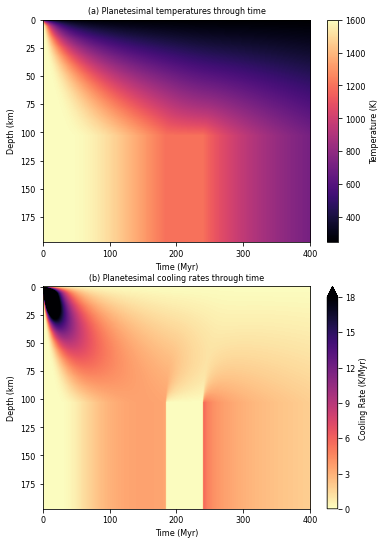

In [16]:
fig_w = 6
fig_h = 9

load_plot_save.two_in_one(
    fig_w,
    fig_h,
    mantle_temperature_array,
    core_temperature_array,
    mantle_cooling_rates,
    core_cooling_rates,
    timestep=timestep)